# Soccer Prophet: Modeling

### By: Roman Kovalchuk

## Table of Contents:
* [Notebook Intro](#notebook)
* [Importing Libraries and Dataset](#importing)
* [Covariance](#covariance)
* [Setting the Target Variable and Splitting the Data](#splitting)
* [Modeling Considerations](#considerations)
* [Logistic Regression](#logistic)
* [Logistic GridSearch](#lgrid)
* [Odds Ratio](#odds)
* [Support Vector Machiens (SVM)](#svm)
* [SVM GridSearch](#SVMGrid)
* [XGBoost](#xgboost)
* [XGBoost GridSearch](#XGGrid)
* [Modeling Conclusions](#mconclusions)
* [Conclusion](#conclusion)

## Notebook Intro<a class="anchor" id="notebook"></a>

Now that we've cleaned, explored and wrangled our data, we are ready to move on to the modeling portion. The three models that we will be using are Logistic Regression, SVM, and XGBoost.

## Importing Libraries and Dataset<a class="anchor" id="importing"></a>

Let's import the libraries that we will be using:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Now let's import our dataset which we cleaned, wrangled, and engineered in our previous notebook:

In [2]:
#importing data
modeling_data = pd.read_csv("Euro_Football_For_Modelling.csv")

In [249]:
#checking data
modeling_data.head()

,HomeScore,AwayScore,Result,HalfTimeHomeGoals,HalfTimeAwayGoals,HalfTimeResult,HomeShots,AwayShots,HomeShotsOnTarget,AwayShotsOnTarget,HomeFouls,AwayFouls,HomeCorners,AwayCorners,HomeYellowCards,AwayYellowCards,HomeRedCards,AwayRedCards,Year,Month,Day,HomeTeam_Ajaccio,HomeTeam_Ajaccio GFCO,HomeTeam_Alaves,HomeTeam_Almeria,HomeTeam_Amiens,HomeTeam_Angers,HomeTeam_Arsenal,HomeTeam_Aston Villa,HomeTeam_Atalanta,HomeTeam_Ath Bilbao,HomeTeam_Ath Madrid,HomeTeam_Augsburg,HomeTeam_Barcelona,HomeTeam_Bastia,HomeTeam_Bayern Munich,HomeTeam_Benevento,HomeTeam_Betis,HomeTeam_Bielefeld,HomeTeam_Bochum,HomeTeam_Bologna,HomeTeam_Bordeaux,HomeTeam_Bournemouth,HomeTeam_Braunschweig,HomeTeam_Brentford,HomeTeam_Brescia,HomeTeam_Brest,HomeTeam_Brighton,HomeTeam_Burnley,HomeTeam_Cadiz,HomeTeam_Caen,HomeTeam_Cagliari,HomeTeam_Cardiff,HomeTeam_Carpi,HomeTeam_Catania,HomeTeam_Celta,HomeTeam_Cesena,HomeTeam_Chelsea,HomeTeam_Chievo,HomeTeam_Clermont,HomeTeam_Cordoba,HomeTeam_Crotone,HomeTeam_Crystal Palace,HomeTeam_Darmstadt,HomeTeam_Dijon,HomeTeam_Dortmund,HomeTeam_Eibar,HomeTeam_Ein Frankfurt,HomeTeam_Elche,HomeTeam_Empoli,HomeTeam_Espanol,HomeTeam_Everton,HomeTeam_Evian Thonon Gaillard,HomeTeam_FC Koln,HomeTeam_Fiorentina,HomeTeam_Fortuna Dusseldorf,HomeTeam_Freiburg,HomeTeam_Frosinone,HomeTeam_Fulham,HomeTeam_Genoa,HomeTeam_Getafe,HomeTeam_Girona,HomeTeam_Granada,HomeTeam_Greuther Furth,HomeTeam_Guingamp,HomeTeam_Hamburg,HomeTeam_Hannover,HomeTeam_Hertha,HomeTeam_Hoffenheim,HomeTeam_Huddersfield,HomeTeam_Huesca,HomeTeam_Hull,HomeTeam_Ingolstadt,HomeTeam_Inter,HomeTeam_Juventus,HomeTeam_La Coruna,HomeTeam_Las Palmas,HomeTeam_Lazio,HomeTeam_Lecce,HomeTeam_Leeds,HomeTeam_Leganes,HomeTeam_Leicester,HomeTeam_Lens,HomeTeam_Levante,HomeTeam_Leverkusen,HomeTeam_Lille,HomeTeam_Liverpool,HomeTeam_Livorno,HomeTeam_Lorient,HomeTeam_Lyon,HomeTeam_M'gladbach,HomeTeam_Mainz,HomeTeam_Malaga,HomeTeam_Mallorca,HomeTeam_Man City,HomeTeam_Man United,HomeTeam_Marseille,HomeTeam_Metz,HomeTeam_Middlesbrough,HomeTeam_Milan,HomeTeam_Monaco,HomeTeam_Montpellier,HomeTeam_Nancy,HomeTeam_Nantes,HomeTeam_Napoli,HomeTeam_Newcastle,HomeTeam_Nice,HomeTeam_Nimes,HomeTeam_Norwich,HomeTeam_Nurnberg,HomeTeam_Osasuna,HomeTeam_Paderborn,HomeTeam_Palermo,HomeTeam_Paris SG,HomeTeam_Parma,HomeTeam_Pescara,HomeTeam_QPR,HomeTeam_RB Leipzig,HomeTeam_Real Madrid,HomeTeam_Reims,HomeTeam_Rennes,HomeTeam_Roma,HomeTeam_Salernitana,HomeTeam_Sampdoria,HomeTeam_Sassuolo,HomeTeam_Schalke 04,HomeTeam_Sevilla,HomeTeam_Sheffield United,HomeTeam_Sochaux,HomeTeam_Sociedad,HomeTeam_Southampton,HomeTeam_Sp Gijon,HomeTeam_Spal,HomeTeam_Spezia,HomeTeam_St Etienne,HomeTeam_Stoke,HomeTeam_Strasbourg,HomeTeam_Stuttgart,HomeTeam_Sunderland,HomeTeam_Swansea,HomeTeam_Torino,HomeTeam_Tottenham,HomeTeam_Toulouse,HomeTeam_Troyes,HomeTeam_Udinese,HomeTeam_Union Berlin,HomeTeam_Valencia,HomeTeam_Valenciennes,HomeTeam_Valladolid,HomeTeam_Vallecano,HomeTeam_Venezia,HomeTeam_Verona,HomeTeam_Villarreal,HomeTeam_Watford,HomeTeam_Werder Bremen,HomeTeam_West Brom,HomeTeam_West Ham,HomeTeam_Wolfsburg,HomeTeam_Wolves,AwayTeam_Ajaccio,AwayTeam_Ajaccio GFCO,AwayTeam_Alaves,AwayTeam_Almeria,AwayTeam_Amiens,AwayTeam_Angers,AwayTeam_Arsenal,AwayTeam_Aston Villa,AwayTeam_Atalanta,AwayTeam_Ath Bilbao,AwayTeam_Ath Madrid,AwayTeam_Augsburg,AwayTeam_Barcelona,AwayTeam_Bastia,AwayTeam_Bayern Munich,AwayTeam_Benevento,AwayTeam_Betis,AwayTeam_Bielefeld,AwayTeam_Bochum,AwayTeam_Bologna,AwayTeam_Bordeaux,AwayTeam_Bournemouth,AwayTeam_Braunschweig,AwayTeam_Brentford,AwayTeam_Brescia,AwayTeam_Brest,AwayTeam_Brighton,AwayTeam_Burnley,AwayTeam_Cadiz,AwayTeam_Caen,AwayTeam_Cagliari,AwayTeam_Cardiff,AwayTeam_Carpi,AwayTeam_Catania,AwayTeam_Celta,AwayTeam_Cesena,AwayTeam_Chelsea,AwayTeam_Chievo,AwayTeam_Clermont,AwayTeam_Cordoba,AwayTeam_Crotone,AwayTeam_Crystal Palace,AwayTeam_Darmstadt,AwayTeam_Dijon,AwayTeam_Dortmund,AwayTeam_Eibar,AwayTeam_Ein Frankfurt,AwayTeam_Elche,AwayTeam_Empoli,AwayTeam_Espanol,AwayTeam_Everton,AwayTeam_Evian Thonon Gaillar

## Covariance<a class="anchor" id="covariance"></a>

Before we get into modelling, let's check the covariance for our Logistic Regression. Since we have 350 categories, we will exclude the dummy variables of our teams since we will be using those to predict the matches, and run an analysis on our other columns.

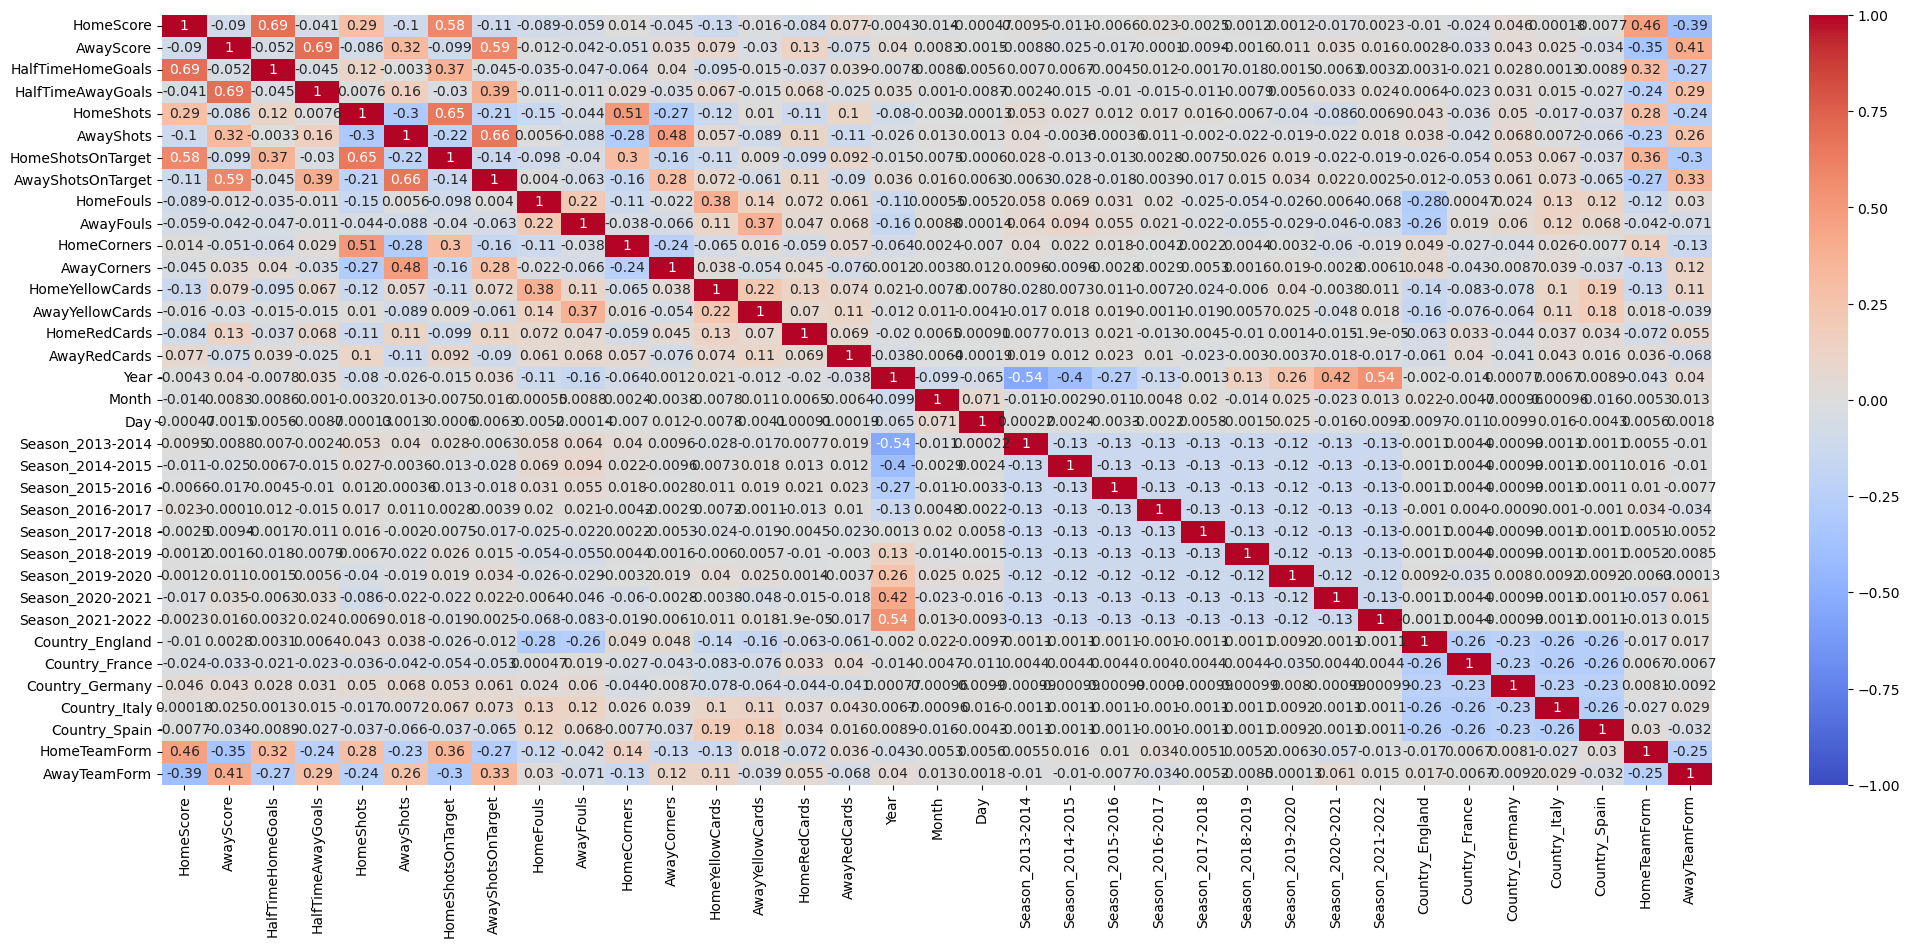

In [5]:
#grouping columns
covariance_columns = ['HomeScore', 'AwayScore', 'HalfTimeHomeGoals', "HalfTimeAwayGoals", 
                      "HomeShots", "AwayShots", "HomeShotsOnTarget", "AwayShotsOnTarget", "HomeFouls", "AwayFouls", 
                      "HomeCorners", "AwayCorners", "HomeYellowCards", "AwayYellowCards", "HomeRedCards", "AwayRedCards", 
                      "Year", "Month", "Day", "Season_2013-2014", "Season_2014-2015", "Season_2015-2016", "Season_2016-2017", 
                      "Season_2017-2018", "Season_2018-2019", "Season_2019-2020", "Season_2020-2021", "Season_2021-2022",
                     "Country_England", "Country_France", "Country_Germany", "Country_Italy", "Country_Spain", "HomeTeamForm", "AwayTeamForm"
                      ]
#covariance dataframe
covariance_data = modeling_data[covariance_columns]

plt.subplots(figsize=(25, 10))
sns.heatmap(covariance_data.corr(), cmap='coolwarm', annot=True, vmin=-1, vmax=1) 
plt.show()

We see some high positive and negative correlations between `HomeScore`, `AwayScore`, `HalfTimeHomeGoals`, and `HalfTimeAwayGoals`. `HomeScore` is predictive of `HalfTimeHomeScores` because they both represent the amount of goals scored at 2 points in the match. Unsurprisingly the Home portion is negatively correlated with the Away portion of both goal categories, and vice versa. Since these columns are also highly predictive of our target variable, we won't be using them in our modelling.

## Setting the Target Variables and Splitting the Data<a class="anchor" id="splitting"></a>

Now let's set our target variable, which is `Result`. It is a multi-class classification with the possible outcomes being "Home Win", "Away Win", and "Draw. As a reminder, here is the distribution of the variable. 

In [6]:
#distribution of Result
modeling_data["Result"].value_counts()/ len(modeling_data) * 100

H    44.611805
A    30.467793
D    24.920402
Name: Result, dtype: float64

Let's visualize this information:

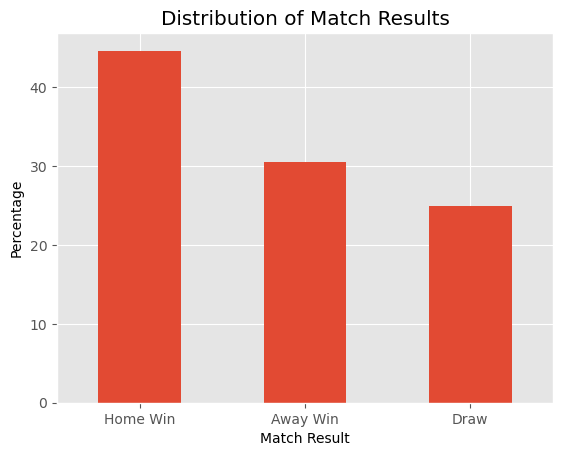

In [264]:
#changing the style of the plot
plt.style.use("ggplot")

# Create a bar plot of the value counts
(modeling_data["Result"].value_counts() / len(modeling_data) * 100).plot(kind="bar")

# Set the title and labels
plt.title("Distribution of Match Results")
plt.xlabel("Match Result")
plt.ylabel("Percentage")
plt.xticks(range(3), ["Home Win", "Away Win", "Draw"])
plt.xticks(rotation=0)

# Show the plot
plt.show()

The home team wins 44% of the time, with the away team winning 30% and 25% of matches resulting in Draws. This shows that home advantage is present in this dataset. 

Now, let's split our target to the y variable and our features to X. We will drop the highly correlated columns mentioned above.

In [7]:
X = modeling_data.drop(['Result', 'HalfTimeResult', "HalfTimeHomeGoals", "HalfTimeAwayGoals", 'HomeScore', 'AwayScore'], axis=1) # Select features except target variable
y = modeling_data['Result'] # Target variable

Now, let's do a train/test split. We will first split the data into Test and Remainder, with the Test set being 30% of the data, and then split the remainder in to train and validation, with validation being 30% of the remainder. We will also stratify splits to y and the then y_remainder in order to preserve the proportion of our target variable. This is important because it can ensure that our train and test sets are representative of the overall target, which can help to preserve the overall distribution and improve accuracy of our model. Splitting into remainder and test ensure that we have no data leakage and that the final model is run on unseen data.

In [15]:
from sklearn.model_selection import train_test_split

# Split the data into test and remainder sets
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Split the remainder set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_remainder, y_remainder, test_size=0.3, random_state=42, stratify=y_remainder)

print(f'Shape of remainder set: {X_remainder.shape}')
print(f'Shape of test set: {X_test.shape}')
print(f'Shape of train set: {X_train.shape}')
print(f'Shape of validation set: {X_val.shape}')

Shape of remainder set: (11432, 347)
Shape of test set: (4900, 347)
Shape of train set: (8002, 347)
Shape of validation set: (3430, 347)


## Modeling Considerations<a class="anchor" id="considerations"></a>

The models that will be used are:
- Logistic Regression
- SVM
- XGBoost

We will first analsze the parameters for each model and fit the training data and score on the validation set. After that, we will fit them onto the GridSearch using the remainder set and then score them on the test set. We will then calculate and analsze the `Accuracy`, `Precision`, `Recall`, and `F1` for the test data.

- `Accuracy` measures the proportion of correct predictions out of all predictions.
- `Precision` measures the fraction of correct positive predictions out of all positive predictions. It is the ratio of True Positives (TP) to the sum of True Positives and False Positives (FP). It predicts how often the model is correct when it predicts a positive outcome.
- `Recall` measures the fraction of correctly identified positive instances out of all positive instances, the ratio of TP to the sum of TP and False Negatives (FN). It predicts how often a model identifies a correct positive instance.
- `F1` score is the harmonic mean of precision and recall. It combines precision and recall into a single score and calculates them on a scale of 0 and 1 with 1 being the best outcome. It is a balanced measure between precision and recall. 

## Logistic Regression<a class="anchor" id="logistic"></a>

Logistic Regression is a statistical model used for classification problems, where the goal is to predict the outcome of variables based on one or more predictor. It is a technique used to estimate the probability of an event occurring based on the values of the predictor. Though it is usually used to binary problems, in our multiclass example, it will use a one-vs-rest strategy, which involves training a separate binary logistic regression classifier for each class. 

First let's run a regression optimizing for the C value which controls the regularization. Lower values symbolize stronger regularization while larger values weaker regularization. Smaller values are less likely to overfit the data but let's try a range in our first model:

In [266]:
#importing logistic regression
from sklearn.linear_model import LogisticRegression

#C values to try
C_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

#setting up train and accuracy lists
train_acc=[]
val_acc=[]

for c in C_values:
    
    # Instantiate the Logistic Model 
    LR_model= LogisticRegression(C=c, max_iter=7000)
    LR_model.fit(X_train, y_train)
    
    # score on train and test
    train_accuracy = LR_model.score(X_train, y_train)
    val_accuracy = LR_model.score(X_val, y_val)
    
    #appending train and test scores
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)

Let's visualize the accuracy for different C Values:

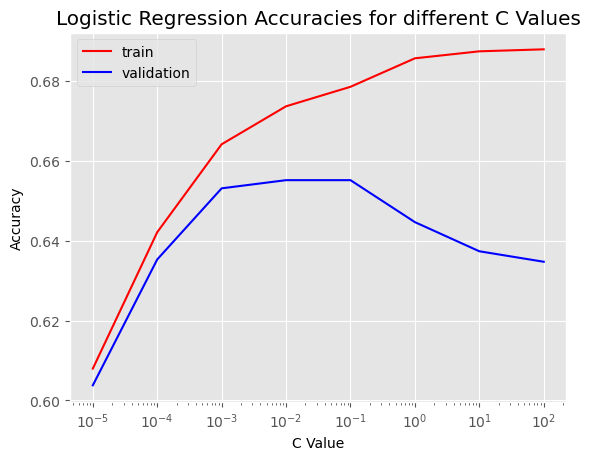

In [268]:
#plotting accuracies
plt.figure()
plt.plot(C_values, train_acc, c='red', label='train')
plt.plot(C_values, val_acc, c='blue', label='validation')

#plotting x and y labels
plt.xlabel('C Value')
plt.ylabel('Accuracy')
plt.xscale('log')

#plotting title and legend
plt.title("Logistic Regression Accuracies for different C Values")
plt.legend()
plt.show()

Let's select the C value of 0.001 for our final model

In [290]:
# Getting our best Logistic Regression
# Instantiate the model 
logreg = LogisticRegression(C=0.001, max_iter=7000)

# Fit the model 
logreg.fit(X_train, y_train)

# Score the model 
print(f"Train score is: {round(logreg.score(X_train, y_train), 3)}")
print(f"Validation score is: {round(logreg.score(X_val, y_val), 3)}")

Train score is: 0.664
Validation score is: 0.653


We achieved a score of 66% on the train set and 65% of validation. This is pretty good considering if our model chose `Home Wins` every time, it would be 44% accurate. However, we haven't done any scaling, penalties, and solvers, which we can do when initiating our GridSearch.

## Logistic GridSearch<a class="anchor" id="lgrid"></a>

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

# estimators
estimators = [('scaling', MinMaxScaler()),
              ('model', LogisticRegression())]

# instantiate pipeline with the specified steps
pipe = Pipeline(estimators)

# define parameter grid
param_grid = {
              'scaling': [MinMaxScaler(), StandardScaler()],
              'model': [LogisticRegression(max_iter=1000)],
              'model__penalty': ['l1', 'l2'],
              'model__solver': ['liblinear', 'lbfgs'],
              'model__C': [0.001, 0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09 ,0.1, 1, 10, 100, 1000],
              'model__random_state': [1]}

# instantiate cross-validated grid search object with the steps and parameter grid
grid_logit = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = 5,
    verbose = 5,
    n_jobs = -1
)

# fit the grid to the unprocessed training data
grid_logit.fit(X_remainder, y_remainder);

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 3/5] END model=LogisticRegression(max_iter=1000), model__C=0.001, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler();, score=0.446 total time=   0.4s
[CV 3/5] END model=LogisticRegression(max_iter=1000), model__C=0.001, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=StandardScaler();, score=0.619 total time=   1.0s
[CV 3/5] END model=LogisticRegression(max_iter=1000), model__C=0.001, model__penalty=l1, model__random_state=1, model__solver=lbfgs, scaling=MinMaxScaler();, score=nan total time=   0.1s
[CV 5/5] END model=LogisticRegression(max_iter=1000), model__C=0.001, model__penalty=l1, model__random_state=1, model__solver=lbfgs, scaling=MinMaxScaler();, score=nan total time=   0.2s
[CV 3/5] END model=LogisticRegression(max_iter=1000), model__C=0.001, model__penalty=l1, model__random_state=1, model__solver=lbfgs, scaling=StandardScaler();, score=nan total

[CV 3/5] END model=LogisticRegression(max_iter=1000), model__C=0.03, model__penalty=l2, model__random_state=1, model__solver=lbfgs, scaling=StandardScaler();, score=0.653 total time=   1.5s[CV 2/5] END model=LogisticRegression(max_iter=1000), model__C=0.001, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler();, score=0.446 total time=   0.3s
[CV 1/5] END model=LogisticRegression(max_iter=1000), model__C=0.001, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=StandardScaler();, score=0.611 total time=   0.9s
[CV 1/5] END model=LogisticRegression(max_iter=1000), model__C=0.001, model__penalty=l1, model__random_state=1, model__solver=lbfgs, scaling=MinMaxScaler();, score=nan total time=   0.1s
[CV 2/5] END model=LogisticRegression(max_iter=1000), model__C=0.001, model__penalty=l1, model__random_state=1, model__solver=lbfgs, scaling=MinMaxScaler();, score=nan total time=   0.2s
[CV 1/5] END model=LogisticRegression(max_iter=10

[CV 3/5] END model=LogisticRegression(max_iter=1000), model__C=0.04, model__penalty=l2, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler();, score=0.640 total time=   0.6s[CV 1/5] END model=LogisticRegression(max_iter=1000), model__C=0.001, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler();, score=0.446 total time=   0.4s
[CV 2/5] END model=LogisticRegression(max_iter=1000), model__C=0.001, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=StandardScaler();, score=0.625 total time=   0.9s
[CV 5/5] END model=LogisticRegression(max_iter=1000), model__C=0.001, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=StandardScaler();, score=0.628 total time=   0.9s
[CV 3/5] END model=LogisticRegression(max_iter=1000), model__C=0.001, model__penalty=l2, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler();, score=0.449 total time=   0.4s
[CV 2/5] END model=LogisticRegres

[CV 2/5] END model=LogisticRegression(max_iter=1000), model__C=0.04, model__penalty=l1, model__random_state=1, model__solver=lbfgs, scaling=MinMaxScaler();, score=nan total time=   0.2s[CV 4/5] END model=LogisticRegression(max_iter=1000), model__C=0.001, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler();, score=0.446 total time=   0.3s
[CV 5/5] END model=LogisticRegression(max_iter=1000), model__C=0.001, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler();, score=0.446 total time=   0.3s
[CV 4/5] END model=LogisticRegression(max_iter=1000), model__C=0.001, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=StandardScaler();, score=0.613 total time=   0.9s
[CV 4/5] END model=LogisticRegression(max_iter=1000), model__C=0.001, model__penalty=l1, model__random_state=1, model__solver=lbfgs, scaling=MinMaxScaler();, score=nan total time=   0.2s
[CV 2/5] END model=LogisticRegression(max_iter=

[CV 5/5] END model=LogisticRegression(max_iter=1000), model__C=0.04, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=StandardScaler();, score=0.657 total time=   2.2s
[CV 2/5] END model=LogisticRegression(max_iter=1000), model__C=0.04, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler();, score=0.647 total time=   0.7s
[CV 2/5] END model=LogisticRegression(max_iter=1000), model__C=0.04, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=StandardScaler();, score=0.652 total time=   2.3s
[CV 1/5] END model=LogisticRegression(max_iter=1000), model__C=0.04, model__penalty=l1, model__random_state=1, model__solver=lbfgs, scaling=MinMaxScaler();, score=nan total time=   0.2s
[CV 3/5] END model=LogisticRegression(max_iter=1000), model__C=0.04, model__penalty=l1, model__random_state=1, model__solver=lbfgs, scaling=MinMaxScaler();, score=nan total time=   0.2s
[CV 1/5] END model=LogisticRegression(max_iter=1

[CV 5/5] END model=LogisticRegression(max_iter=1000), model__C=0.07, model__penalty=l2, model__random_state=1, model__solver=lbfgs, scaling=MinMaxScaler();, score=0.651 total time=   2.0s
[CV 5/5] END model=LogisticRegression(max_iter=1000), model__C=0.04, model__penalty=l2, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler();, score=0.648 total time=   0.6s
[CV 4/5] END model=LogisticRegression(max_iter=1000), model__C=0.04, model__penalty=l2, model__random_state=1, model__solver=liblinear, scaling=StandardScaler();, score=0.654 total time=   3.9s
[CV 2/5] END model=LogisticRegression(max_iter=1000), model__C=0.04, model__penalty=l2, model__random_state=1, model__solver=lbfgs, scaling=MinMaxScaler();, score=0.631 total time=   2.1s
[CV 1/5] END model=LogisticRegression(max_iter=1000), model__C=0.04, model__penalty=l2, model__random_state=1, model__solver=lbfgs, scaling=StandardScaler();, score=0.636 total time=   1.6s
[CV 4/5] END model=LogisticRegression(max_iter=1

[CV 1/5] END model=LogisticRegression(max_iter=1000), model__C=0.08, model__penalty=l2, model__random_state=1, model__solver=liblinear, scaling=StandardScaler();, score=0.627 total time=   4.5s
[CV 5/5] END model=LogisticRegression(max_iter=1000), model__C=0.04, model__penalty=l1, model__random_state=1, model__solver=lbfgs, scaling=MinMaxScaler();, score=nan total time=   0.2s
[CV 3/5] END model=LogisticRegression(max_iter=1000), model__C=0.04, model__penalty=l1, model__random_state=1, model__solver=lbfgs, scaling=StandardScaler();, score=nan total time=   0.3s
[CV 1/5] END model=LogisticRegression(max_iter=1000), model__C=0.04, model__penalty=l2, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler();, score=0.622 total time=   0.7s
[CV 4/5] END model=LogisticRegression(max_iter=1000), model__C=0.04, model__penalty=l2, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler();, score=0.633 total time=   0.6s
[CV 3/5] END model=LogisticRegression(max_iter=1

[CV 3/5] END model=LogisticRegression(max_iter=1000), model__C=0.08, model__penalty=l2, model__random_state=1, model__solver=liblinear, scaling=StandardScaler();, score=0.650 total time=   4.6s
[CV 5/5] END model=LogisticRegression(max_iter=1000), model__C=0.08, model__penalty=l2, model__random_state=1, model__solver=liblinear, scaling=StandardScaler();, score=0.651 total time=   4.1s
[CV 2/5] END model=LogisticRegression(max_iter=1000), model__C=0.08, model__penalty=l2, model__random_state=1, model__solver=lbfgs, scaling=StandardScaler();, score=0.624 total time=   1.9s
[CV 1/5] END model=LogisticRegression(max_iter=1000), model__C=0.09, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler();, score=0.647 total time=   1.0s
[CV 2/5] END model=LogisticRegression(max_iter=1000), model__C=0.09, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler();, score=0.650 total time=   1.3s
[CV 1/5] END model=LogisticRegression(


[CV 1/5] END model=LogisticRegression(max_iter=1000), model__C=0.08, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler();, score=0.648 total time=   1.0s
[CV 2/5] END model=LogisticRegression(max_iter=1000), model__C=0.08, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler();, score=0.650 total time=   1.0s
[CV 2/5] END model=LogisticRegression(max_iter=1000), model__C=0.08, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=StandardScaler();, score=0.642 total time=   2.9s
[CV 1/5] END model=LogisticRegression(max_iter=1000), model__C=0.08, model__penalty=l1, model__random_state=1, model__solver=lbfgs, scaling=MinMaxScaler();, score=nan total time=   0.2s
[CV 2/5] END model=LogisticRegression(max_iter=1000), model__C=0.08, model__penalty=l1, model__random_state=1, model__solver=lbfgs, scaling=MinMaxScaler();, score=nan total time=   0.2s
[CV 3/5] END model=LogisticRegression(max_iter=10


[CV 2/5] END model=LogisticRegression(max_iter=1000), model__C=0.08, model__penalty=l2, model__random_state=1, model__solver=lbfgs, scaling=MinMaxScaler();, score=0.642 total time=   2.7s
[CV 5/5] END model=LogisticRegression(max_iter=1000), model__C=0.08, model__penalty=l2, model__random_state=1, model__solver=lbfgs, scaling=MinMaxScaler();, score=0.649 total time=   2.6s
[CV 4/5] END model=LogisticRegression(max_iter=1000), model__C=0.08, model__penalty=l2, model__random_state=1, model__solver=lbfgs, scaling=StandardScaler();, score=0.654 total time=   1.9s
[CV 4/5] END model=LogisticRegression(max_iter=1000), model__C=0.09, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler();, score=0.657 total time=   0.9s
[CV 3/5] END model=LogisticRegression(max_iter=1000), model__C=0.09, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=StandardScaler();, score=0.658 total time=   2.7s
[CV 1/5] END model=LogisticRegression(max_iter=


[CV 2/5] END model=LogisticRegression(max_iter=1000), model__C=0.04, model__penalty=l2, model__random_state=1, model__solver=liblinear, scaling=StandardScaler();, score=0.631 total time=   3.9s
[CV 5/5] END model=LogisticRegression(max_iter=1000), model__C=0.04, model__penalty=l2, model__random_state=1, model__solver=liblinear, scaling=StandardScaler();, score=0.653 total time=   3.3s
[CV 2/5] END model=LogisticRegression(max_iter=1000), model__C=0.04, model__penalty=l2, model__random_state=1, model__solver=lbfgs, scaling=StandardScaler();, score=0.624 total time=   1.7s
[CV 1/5] END model=LogisticRegression(max_iter=1000), model__C=0.05, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler();, score=0.641 total time=   0.8s
[CV 3/5] END model=LogisticRegression(max_iter=1000), model__C=0.05, model__penalty=l1, model__random_state=1, model__solver=liblinear, scaling=MinMaxScaler();, score=0.650 total time=   0.9s
[CV 1/5] END model=LogisticRegression

In [34]:
#scoring on remainder
grid_logit.score(X_remainder,y_remainder)

0.6613016095171449

In [35]:
#obtaining best parameters
grid_logit.best_params_

{'model': LogisticRegression(C=0.02, max_iter=1000, penalty='l1', random_state=1,
                    solver='liblinear'),
 'model__C': 0.02,
 'model__penalty': 'l1',
 'model__random_state': 1,
 'model__solver': 'liblinear',
 'scaling': StandardScaler()}

Now let's check the best estimator score on our initial train and validation sets. With our first Logistic Regression, we got 66.4% and 65.3% for the train and validation respectively. Let's see what we get with our best estimator:

In [289]:
print(f"Best estimator train score is: {round(grid_logit.best_estimator_.score(X_train, y_train), 3)}")
print(f"Best estimator validation score is: {round(grid_logit.best_estimator_.score(X_val, y_val), 3)}")

Best estimator train score is: 0.665
Best estimator validation score is: 0.653


Looks like we got similar results. Now let's check the remainder and test score:

In [288]:
print(f"Best estimator remainder score is: {round(grid_logit.best_estimator_.score(X_remainder, y_remainder), 3)}")
print(f"Best estimator test score is: {round(grid_logit.best_estimator_.score(X_test, y_test), 3)}")

Best estimator remainder score is: 0.661
Best estimator test score is: 0.658


The remainder and test scores are fairly similar at 66.1% and 65.7%. The test did slightly better than the validation, let's make some predictions with the test and visualize results on a confusion matrix.

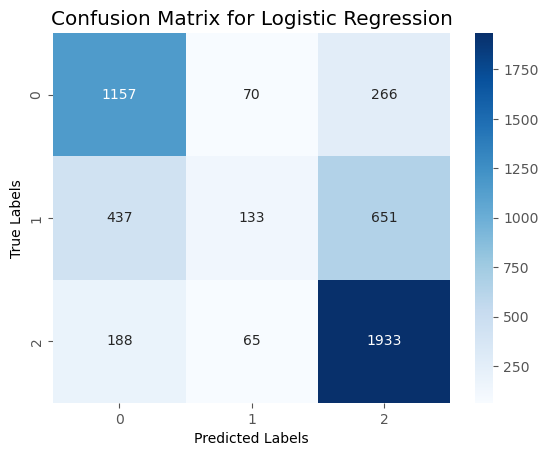

              precision    recall  f1-score   support

           A       0.65      0.77      0.71      1493
           D       0.50      0.11      0.18      1221
           H       0.68      0.88      0.77      2186

    accuracy                           0.66      4900
   macro avg       0.61      0.59      0.55      4900
weighted avg       0.62      0.66      0.60      4900



In [282]:
#importing confusion matrix and classification report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Make predictions using the best estimator from the grid search
y_pred_logit = grid_logit.best_estimator_.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_logit)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred_logit))

Let's input this information into a table which we will update with the results of the other models:

| Model               | Accuracy | Class    | Precision | Recall | F1-Score |
|---------------------|----------|----------|-----------|--------|----------|
| Logistic Regression | 66%      | Away Win | 65%       | 77%    | 71%      |
|                     |          | Draw     | 50%       | 11%    | 18%      |
|                     |          | Home Win | 68%       | 88%    | 77%      |

Looking at the table, we can see that the model has a high precision for predicting Home and Away wins with 65 and 68% score respectively. This means that when a model predicts a Home or Away win, it's right more often than wrong. However, the recall for draws is only 11%. This indicates that the model misses a significant number of Draws and, looking at the Confusion Matrix, falsely predicts them as Away or Home wins. 

Now, let's look closer at the coefficients of our model

### Odds Ratio<a class="anchor" id="odds"></a>

Now, let's take a look at the coefficients that affect each class. These are the columns that are greatly associated with predicting that outcome.

In [191]:
# creating a DataFrame to store coefficients
coef_table = pd.DataFrame(index=X.columns)

# loop over the three classes and compute the coefficients and odds ratios
for i in range(3):
    coef = logreg.coef_[i]
    odds_ratio = np.exp(coef)
    coef_table[f'coefficients_class_{i}'] = coef
    coef_table[f'odds_ratio_class_{i}'] = odds_ratio

#setting class names and amount to display
class_names = ['Away Wins', 'Draws', 'Home Wins']
top_k = 5

#looping through coefficients and setting coeff and odds ratios
for i, class_name in enumerate(class_names):
    class_coef = coef_table[f'coefficients_class_{i}']
    class_odds = coef_table[f'odds_ratio_class_{i}']
    sorted_coef = class_coef.sort_values(ascending=False)
    sorted_odds = class_odds.loc[sorted_coef.index]
    top_coef = sorted_coef[:top_k]
    bottom_coef = sorted_coef[-top_k:]
    top_odds = sorted_odds[:top_k]
    bottom_odds = sorted_odds[-top_k:]
    
    #display top 5 and bottom 5 coeff and odds ratios for each class
    print(f'Top {top_k} positive coefficients and odds ratio for {class_name}:')
    for j in range(top_k):
        print(f'{j+1}. Coefficient: {top_coef.index[j]:<25} Odds Ratio: {top_odds.iloc[j]:.4f}')
    print(f'Top {top_k} negative coefficients and odds ratio for {class_name}:')
    for j in range(top_k):
        print(f'{j+1}. Coefficient: {bottom_coef.index[j]:<25} Odds Ratio: {bottom_odds.iloc[j]:.4f}')
    print()

Top 5 positive coefficients and odds ratio for Away Wins:
1. Coefficient: AwayShotsOnTarget         Odds Ratio: 1.2895
2. Coefficient: AwayTeamForm              Odds Ratio: 1.1346
3. Coefficient: HomeRedCards              Odds Ratio: 1.0829
4. Coefficient: HomeCorners               Odds Ratio: 1.0688
5. Coefficient: HomeShots                 Odds Ratio: 1.0315
Top 5 negative coefficients and odds ratio for Away Wins:
1. Coefficient: AwayShots                 Odds Ratio: 0.9763
2. Coefficient: AwayRedCards              Odds Ratio: 0.9539
3. Coefficient: AwayCorners               Odds Ratio: 0.9424
4. Coefficient: HomeTeamForm              Odds Ratio: 0.8780
5. Coefficient: HomeShotsOnTarget         Odds Ratio: 0.8267

Top 5 positive coefficients and odds ratio for Draws:
1. Coefficient: HomeYellowCards           Odds Ratio: 1.0385
2. Coefficient: HomeCorners               Odds Ratio: 1.0192
3. Coefficient: Season_2018-2019          Odds Ratio: 1.0138
4. Coefficient: HomeShots           

Let's visualize this information:

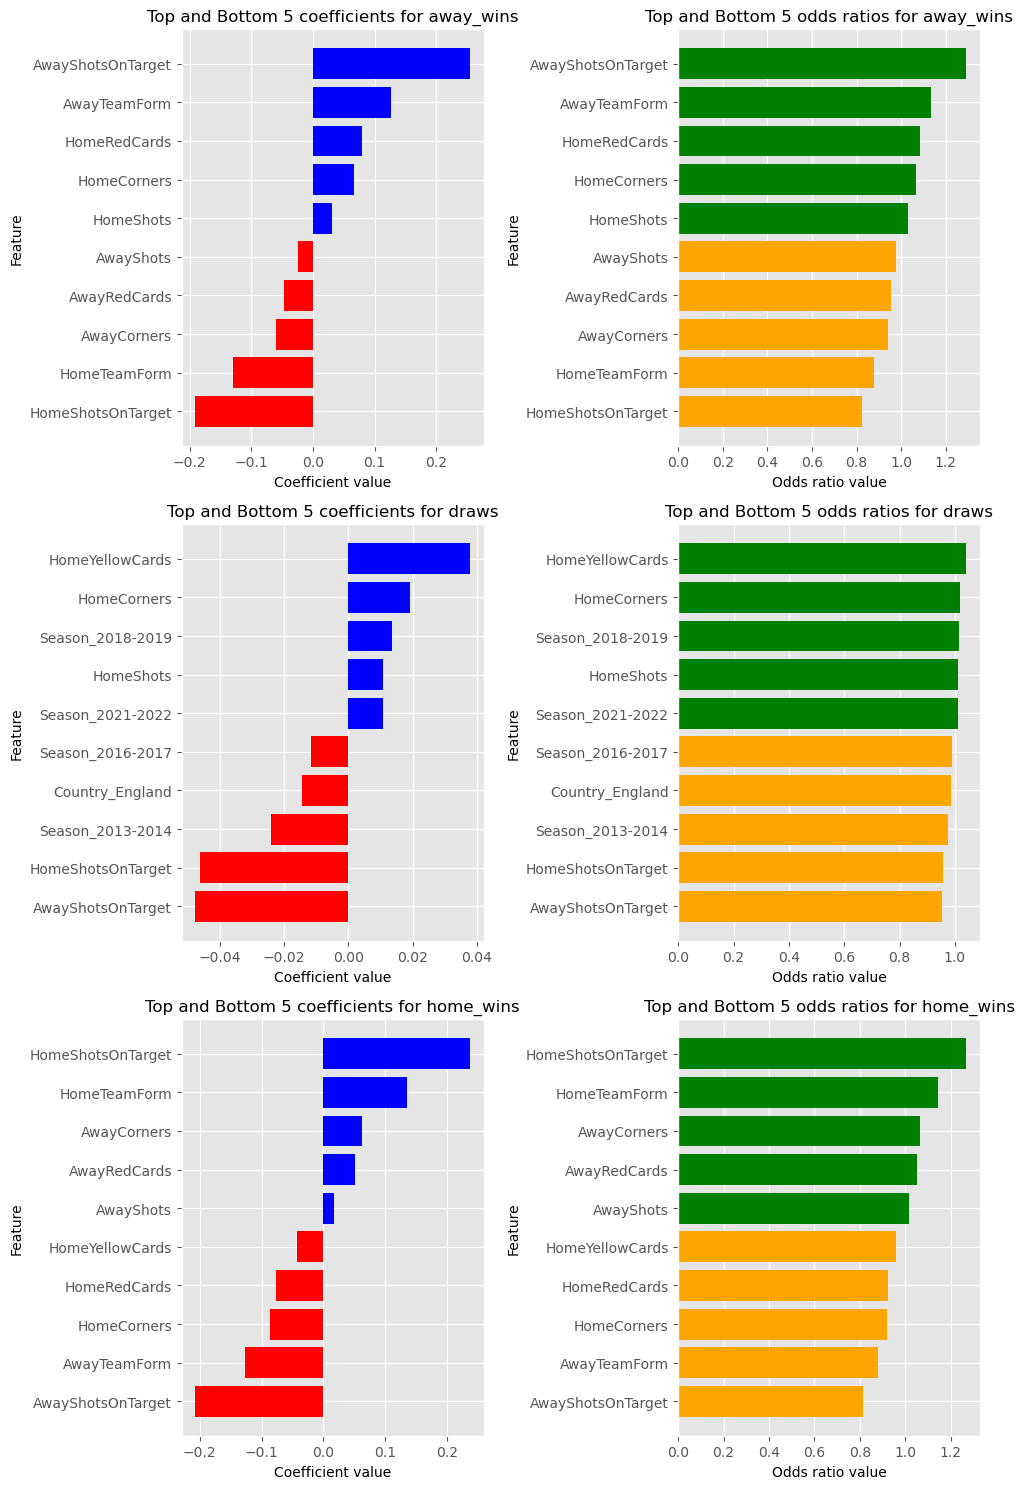

In [281]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10,15))

for i, class_name in enumerate(class_names):
    # Plotting coefficients
    class_coef = coef_table[f'coefficients_class_{i}']
    sorted_coef = class_coef.sort_values(ascending=False)
    top_coef = sorted_coef[:5][::-1]
    bottom_coef = sorted_coef[-5:][::-1] 
    axs[i,0].barh(bottom_coef.index, bottom_coef.values, color='r')
    axs[i,0].barh(top_coef.index, top_coef.values, color='b')
    axs[i,0].set_title(f'Top and Bottom 5 coefficients for {class_name}', fontsize=12)
    axs[i,0].set_xlabel('Coefficient value', fontsize=10)
    axs[i,0].set_ylabel('Feature', fontsize=10)
    
    # Plotting odds ratios
    class_odds = coef_table[f'odds_ratio_class_{i}']
    sorted_odds = class_odds.sort_values(ascending=False)
    top_odds = sorted_odds[:5][::-1]  # Reversed order
    bottom_odds = sorted_odds[-5:][::-1]  # Reversed order
    
    axs[i,1].barh(bottom_odds.index, bottom_odds.values, color='orange')
    axs[i,1].barh(top_odds.index, top_odds.values, color='g')
    axs[i,1].set_title(f'Top and Bottom 5 odds ratios for {class_name}', fontsize=12)
    axs[i,1].set_xlabel('Odds ratio value', fontsize=10)
    axs[i,1].set_ylabel('Feature', fontsize=10)
    
plt.tight_layout()
plt.show()


We can now see which features are more predictive of an Away Win, Draw, or a Home Win. Not surprisingly, Shots on Target and Team Form is the most predictive coefficient with odds ratio for both home and away wins. However, the opponent having more corner kicks seems to be associated with the other teams success for both Home and Away wins. For Home Wins, the Away Team having more corner kicks even edges out them having Red Cards. Perhaps it has to do with the team desperately attacking, having shots blocked by the defense and saved by the keeper for a corner kick. Sometimes the ball just doesn't want to go in.

## Support Vector Machines (SVM)<a class="anchor" id="svm"></a>

Now let's try fitting our data to a Support Vector Machine. SVM works by finding the optimal boundary that maximizes the margin between classes, with the margin being the distance between the boundary and the closest data points of each class. We will check the c value parameter and also the gamma value. Like in Logistic Regression, the C Value controls the tradeoff between a low train and test error, while the gamma essentially controls the distance between classes.

Since SVM is a distance based model, we will need to scale the data beforehand. Let's do this using Standard Scaler:

In [80]:
# Instantiate the scaler
SS = StandardScaler()

# Fit the scaler
SS.fit(X_train)

# Transform the training and test sets 
X_train_ss = SS.transform(X_train)
X_val_ss = SS.transform(X_val)

In [271]:
#importing svm and SVC
from sklearn import svm
from sklearn.svm import SVC

# Empty lists to append to 
train_acc_ss = []
val_acc_ss = []

C_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Looping through the C_values from earlier
for C in C_values: 
    
    # Instantiate the model 
    SVM = SVC(C=C, max_iter=2000)
    
    # Fit
    SVM.fit(X_train_ss, y_train)
    
    # Score
    train_acc_ss.append(SVM.score(X_train_ss, y_train))
    val_acc_ss.append(SVM.score(X_val_ss, y_val))

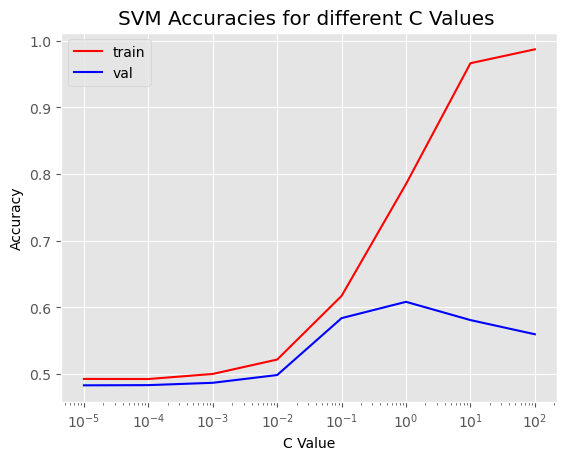

In [272]:
# Plotting the accuracies
plt.figure()
plt.plot(C_values, train_acc_ss, c='red', label='train')
plt.plot(C_values, val_acc_ss, c='blue', label='val')

#naming x and y labels
plt.xlabel('C Value')
plt.ylabel('Accuracy')
plt.xscale('log')

#plotting title and legend
plt.title("SVM Accuracies for different C Values ")
plt.legend()

plt.show()

Looks like the best C value for SVM is 0.1. Now let's check the gamma values.

In [274]:
# Empty lists to append to 
train_acc_ss = []
val_acc_ss = []

gamma_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Looping through the C_values from earlier
for gamma in gamma_values: 
    
    # Instantiate the model 
    SVM = SVC(gamma=gamma, max_iter=2000)
    
    # Fit
    SVM.fit(X_train_ss, y_train)
    
    # Score
    train_acc_ss.append(SVM.score(X_train_ss, y_train))
    val_acc_ss.append(SVM.score(X_val_ss, y_val))

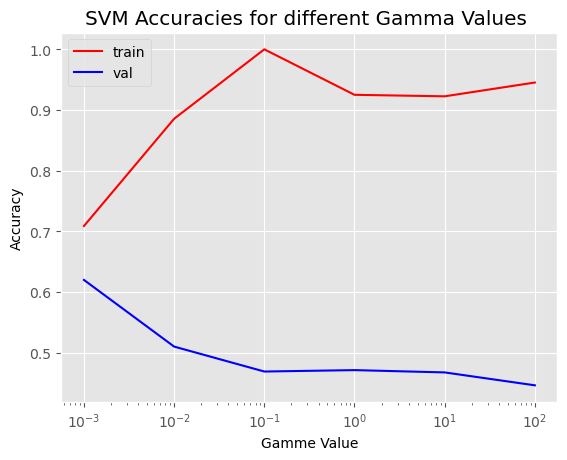

In [275]:
# Plotting the accuracies
plt.figure()
plt.plot(gamma_values, train_acc_ss, c='red', label='train')
plt.plot(gamma_values, val_acc_ss, c='blue', label='val')

#naming axes
plt.xlabel('Gamme Value')
plt.ylabel('Accuracy')
plt.xscale('log')

#plotting title and legend
plt.title("SVM Accuracies for different Gamma Values ")
plt.legend()

plt.show()

Looks like this best gamma to use is 0.001. Now let's fit SVM on our train set and score on validation with a see value of 0.1 and gamma of 0.001 to see what we get.

In [145]:
# Instantiate the model

svm = SVC(gamma=0.001, C=0.1)

# Fitting the model
svm.fit(X_train_ss, y_train)

# Training and test scores
print(f"Train score: {svm.score(X_train_ss, y_train)}")
print(f"Validation score is: {svm.score(X_val_ss, y_val)}")

Train score: 0.5934766308422894
Validation score is: 0.5775510204081633


We get a train score of 59% and a validation score of 58% which is not as good as our initial Logistic Regression model. However, let's optimize our model and run it through a GridSearch to see what the final results are:

## SVM GridSearch<a class="anchor" id="SVMGrid"></a>

Now let's optimize our SVM model with MinMaxScaler, StandardScaler and various gamma and C parameters to see which combination will produce the best accuracy.

In [46]:
from sklearn import svm
from sklearn.svm import SVC

# estimators
estimators = [('scaling', MinMaxScaler()),
              ('model', svm.SVC())]

# instantiate pipeline with the specified steps
pipe = Pipeline(estimators)

# define parameter grid
param_grid = {
              'model': [svm.SVC()], 
              'scaling': [MinMaxScaler(), StandardScaler()],
              'model__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
              'model__C': [0.001, 0.01, 0.1, 1, 10, 100]
}
# instantiate cross-validated grid search object with the steps and parameter grid
grid_svm = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = 5,
    verbose = 5,
    n_jobs = -1
)

# fit the grid to the unprocessed training data
grid_svm.fit(X_remainder, y_remainder);

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [48]:
grid_svm.score(X_remainder,y_remainder)

[CV 4/5] END model=SVC(), model__C=0.001, model__gamma=0.001, scaling=MinMaxScaler();, score=0.446 total time= 1.4min
[CV 3/5] END model=SVC(), model__C=0.001, model__gamma=0.001, scaling=StandardScaler();, score=0.446 total time= 1.5min
[CV 2/5] END model=SVC(), model__C=0.001, model__gamma=0.01, scaling=MinMaxScaler();, score=0.446 total time= 1.7min
[CV 5/5] END model=SVC(), model__C=0.001, model__gamma=0.01, scaling=MinMaxScaler();, score=0.446 total time= 1.5min
[CV 3/5] END model=SVC(), model__C=0.001, model__gamma=0.01, scaling=StandardScaler();, score=0.446 total time= 1.5min
[CV 3/5] END model=SVC(), model__C=0.001, model__gamma=0.1, scaling=MinMaxScaler();, score=0.446 total time= 1.6min
[CV 2/5] END model=SVC(), model__C=0.001, model__gamma=0.1, scaling=StandardScaler();, score=0.446 total time= 2.0min
[CV 1/5] END model=SVC(), model__C=0.001, model__gamma=1, scaling=MinMaxScaler();, score=0.446 total time= 2.0min
[CV 5/5] END model=SVC(), model__C=0.001, model__gamma=1, sca

0.684482155353394

Our best score on the validation is 68%, now let's see which parameters brought us here.

In [66]:
#checking the best parameters
grid_svm.best_params_

{'model': SVC(C=10, gamma=0.01),
 'model__C': 10,
 'model__gamma': 0.01,
 'scaling': MinMaxScaler()}

The best SVM model has a C value of 10, gamma of 0.01 and uses the MinMaxScaler

Now let's check the best estimator score on the train, validation, remainder and test sets.

In [291]:
print(f"Best estimator remainder score is: {round(grid_svm.best_estimator_.score(X_remainder, y_remainder), 3)}")
print(f"Best estimator test score is: {round(grid_svm.best_estimator_.score(X_test, y_test), 3)}")
print(f"Best estimator train score is: {round(grid_svm.best_estimator_.score(X_train, y_train), 3)}")
print(f"Best estimator validation score is: {round(grid_svm.best_estimator_.score(X_val, y_val), 3)}")

Best estimator remainder score is: 0.684
Best estimator test score is: 0.656
Best estimator train score is: 0.687
Best estimator validation score is: 0.678


The grid search greatly improved our train and validation score from 59% to 69% and 57% to 67% respectively, which is a great improvement. The remainder score was 68% and the final test score was 66%, which is the same as Logistic Regression. Let's pull up a confusion matrix and classification report to observe our results in more detail:

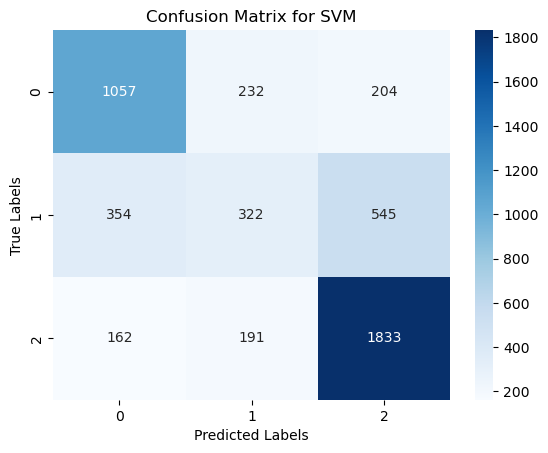

              precision    recall  f1-score   support

           A       0.67      0.71      0.69      1493
           D       0.43      0.26      0.33      1221
           H       0.71      0.84      0.77      2186

    accuracy                           0.66      4900
   macro avg       0.60      0.60      0.60      4900
weighted avg       0.63      0.66      0.63      4900



In [247]:
# Make predictions using the best estimator from the grid search
y_pred_svm = grid_svm.best_estimator_.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred_svm))

Let's update our table: 

| Model               | Accuracy | Class    | Precision | Recall | F1-Score |
|---------------------|----------|----------|-----------|--------|----------|
| Logistic Regression | 66%      | Away Win | 65%       | 77%    | 71%      |
|                     |          | Draw     | 50%       | 11%    | 18%      |
|                     |          | Home Win | 68%       | 88%    | 77%      |
|                     |          |          |           |        |          |
| SVM                 | 66%      | Away Win | 67%       | 71%    | 69%      |
|                     |          | Draw     | 43%       | 26%    | 33%      |
|                     |          | Home Win | 71%       | 84%    | 77%      |

While SVM and Logistic have the same Accuracy, SVM seems to perform better than Logistic in terms of Home and Away Win precision, correctly guessing 71% and 67% of Home and Away Wins. This means that out of all matches predicted as Away Wins, SVM got 67% of them right. The recall is worse for both Win categories but higher for Draws by 15%. While Logistic Regression correctly predicted 50% of all Draws to SVM's 43%, SVM Recalled 26% of the draws to 11% of Logistic's. Logistic wasn't that good at predicting the amount of draws, but when it did predict a Draw, it got it down to a 50% precision. Draws are really tough to predict. In terms of F1, Logistic did slightly better with Away Wins while SVM performed better with Draws. Home Wins had the same precision for both models. 

We can see how tough it is for our model to predict draws as by the Confusion Matrix above, SVM seems to predict them as Home and Away wins. Let's see how well XGBoost does in our predictions.

# XGBoost<a class="anchor" id="xgboost"></a>

XGBoost is an optimized distributed gradient boosting library that can be used for both classification and regression tasks. It uses a set of decision trees to predict the target variable, and the predictions of the individual trees are combined to produce the final prediction. 

First let's run an XGboost to optimize the max_depth and number of estimators features. Max depth, the maximum depth of the three, controls the complexity of the model and helps prevent overfitting. Number of estimators is the number of trees that the model will use to make predictions. First, let's run XGBoost with various max_depth parameters.

In [278]:
#importing xgboost
from xgboost import XGBClassifier

# Empty lists to append to 
train_acc = []
val_acc = []

max_depth = [1, 2, 3, 4, 5]

# Looping through max_depth
for depth in max_depth: 
    
    # Instantiate the model 
    XGB_model = XGBClassifier(max_depth = depth)
    
    # Fit
    XGB_model.fit(X_train, y_train)
    
    # Score
    train_acc.append(XGB_model.score(X_train, y_train))
    val_acc.append(XGB_model.score(X_val, y_val))

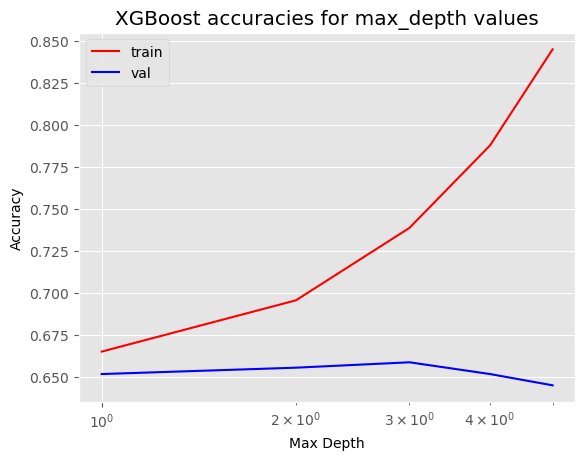

In [279]:
# Plotting the accuracies
plt.figure()
plt.plot(max_depth, train_acc, c='red', label='train')
plt.plot(max_depth, val_acc, c='blue', label='val')

#setting axes
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.xscale('log')

#plotting legend and title
plt.title("XGBoost accuracies for max_depth values")
plt.legend()
plt.show()

Looks like the best `max_boost` value is somewhere around 1, as the train data quickly rises while the vslaidation remains stable before dipping at around 3. Let's also check the number of estimators parameter:

In [276]:
# Empty lists to append to 
train_acc = []
val_acc = []

estimators = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Looping through estimators
for e in estimators: 
    
    # Instantiate the model 
    XGB_model = XGBClassifier(n_estimators = e)
    
    # Fit
    XGB_model.fit(X_train, y_train)
    
    # Score
    train_acc.append(XGB_model.score(X_train, y_train))
    val_acc.append(XGB_model.score(X_val, y_val))

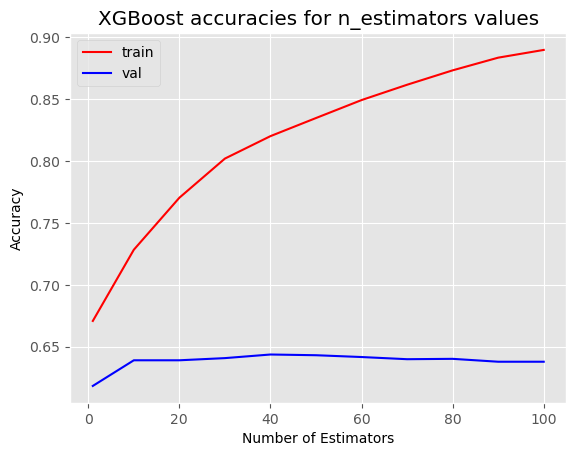

In [277]:
# Plotting the accuracies
plt.figure()
plt.plot(estimators, train_acc, c='red', label='train')
plt.plot(estimators, val_acc, c='blue', label='val')

#setting labels
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')

#title and legend
plt.title("XGBoost accuracies for n_estimators values")
plt.legend()
plt.show()

It seems that the best number of estimators to use is around 10, where the train data continues to rise while the validation flattens out. Let's perform a XGBoost trial with a `max_depth` of 1 and `n_estimators` of 10:

In [160]:
# Instantiating the model
XGB_model = XGBClassifier(max_depth=1, n_estimators=10)

# Fitting model
XGB_model.fit(X_train, y_train)

# Training and test scores
print(f"Train score: {XGB_model.score(X_train, y_train)}")
print(f"Validation score: {XGB_model.score(X_val, y_val)}")

Train score: 0.6255936015996001
Validation score: 0.6186588921282798


The result isn't great with a 63% train score and 62% validation. These scores are lower than the Logistic Regression and SVM scores we obtained, however let's expand our parameters and run a GridSearch to see if the accuracy will improve.

## XGBoost GridSearch<a class="anchor" id="XGGrid"></a>

Now let's optimize our XGBoost with various max_depth and estimators to see the best values:

In [ ]:
# setting estimators
estimators = [('scaling', MinMaxScaler()),
              ('model', XGBClassifier())]

# instantiating pipeline 
pipe = Pipeline(estimators)

# definining grid
param_grid = {
              'scaling': [None],
              'model': [XGBClassifier()], 
              'model__max_depth': range(1, 10),
              'model__n_estimators': np.arange(1, 200, 10),
              'model__random_state': [1]
}
# instantiating gridsearch with cross validaiton value of 5
grid_xgb = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = 5,
    verbose = 5,
    n_jobs = -1
)

# fitting grid on remainder
grid_xgb.fit(X_remainder, y_remainder);

In [77]:
#scoring grid on remainder
grid_xgb.score(X_remainder,y_remainder)

0.6719734079776067

In [159]:
#checking best parametersb
grid_xgb.best_params_

{'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=1,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=181, n_jobs=None, num_parallel_tree=None,
               random_state=1, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=None, tree_method=None,
               validate_parameters=None, verbosity=None),
 'model__max_depth': 1,
 'model__n_estimators': 181,
 'model__random_state': 1,
 'scaling': None}

The best parameters returned a max_depth of 1 and number of estimators of 181. These values were different than the ones we used in the previous model so let's see how they perform on our split datasets.

In [292]:
print(f"Best estimator remainder score is: {round(grid_xgb.best_estimator_.score(X_remainder, y_remainder), 3)}")
print(f"Best estimator test score is: {round(grid_xgb.best_estimator_.score(X_test, y_test), 3)}")
print(f"Best estimator train score is: {round(grid_xgb.best_estimator_.score(X_train, y_train), 3)}")
print(f"Best estimator validation score is: {round(grid_xgb.best_estimator_.score(X_val, y_val), 3)}")

Best estimator remainder score is: 0.672
Best estimator test score is: 0.665
Best estimator train score is: 0.673
Best estimator validation score is: 0.669


The train and validation scores both jump to 67%. The remainder also returns 67% accuracy while the test score completes at 66%. Let's pull up a confusion matrix and classification report to see the results in more detail:

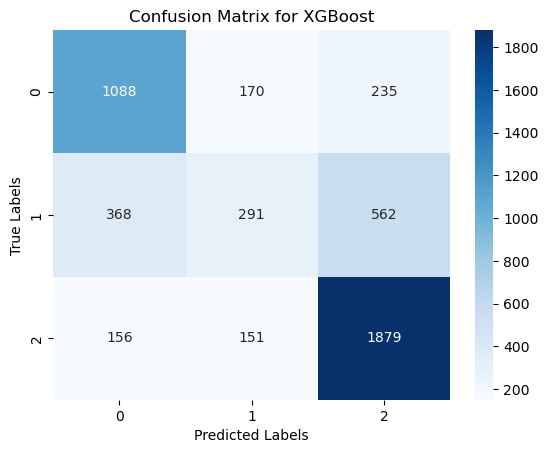

              precision    recall  f1-score   support

           A       0.67      0.73      0.70      1493
           D       0.48      0.24      0.32      1221
           H       0.70      0.86      0.77      2186

    accuracy                           0.66      4900
   macro avg       0.62      0.61      0.60      4900
weighted avg       0.64      0.66      0.64      4900



In [162]:
# Make predictions using the best estimator from the grid search
y_pred_xg = grid_xgb.best_estimator_.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_xg)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred_xg))

Looking at the confusion matrix, XGBoost predicted more home and away wins than SVM but wasn't as effective with draws.

| Model               | Accuracy | Class    | Precision | Recall | F1-Score |
|---------------------|----------|----------|-----------|--------|----------|
| Logistic Regression | 66%      | Away Win | 65%       | <b>77%</b>    | <b>71%</b>      |
|                     |          | Draw     | <b>50%</b>       | 11%    | 18%      |
|                     |          | Home Win | 68%       | <b>88%</b>    | <b>77%</b>      |
|                     |          |          |           |        |          |
| SVM                 | 66%      | Away Win | <b>67%</b>       | 71%    | 69%      |
|                     |          | Draw     | 43%       | <b>26%</b>    | <b>33%</b>      |
|                     |          | Home Win | <b>71%</b>       | 84%    | <b>77% </b>     |
|                     |          |          |           |        |          |
| XGBoost             | 66%      | Away Win |  <b>67%</b>       | 73%    | 70%      |
|                     |          | Draw     | 48%       | 24%    | 32%      |
|                     |          | Home Win | 70%       | 86%    | <b>77%</b>      |

All 3 models offer 66% accuracy, however this isn't a terrible result as the predominant class of "Home Wins" is prevalant 44% of the time. Adding XGBoost to the table, we see a similar performance in terms of precision and recall as SVM. XGBoost seems to do better in terms of Recall for both win categories, but drops down a point in Precision. The F1 scores are strong, with XGBoost outperforming SVM in terms of Away Wins and having the same percentage in Home Wins. 

## Modeling Conclusions<a class="anchor" id="mconclusions"></a>

The model that was most consistent in predicting results was SVM, which had the top precision for Home and Away wins, though didn't do as way on the recall. It was able to distinguish Home and Away wins when classifying them, but didn't get a lot of them right. Logistic Regression was on the opposite side of the spectrum with higher recall for the wins columns, but lower precision. All 3 models struggled with predicting draws, perhaps because there are no clear indicators on identifying them or they mostly come down to luck.

# Conclusion<a class="anchor" id="conclusion"></a>

In this project, we've obtained a dataset, cleaned and explored it, engineered new features, and ran 3 models on it, training it to distinguish between final results with 66% accuracy. Though not the best result, it isn't bad considering one of the classes is difficult to predict. Though a team can win comfortably by 2 or 3 goals, a draw can occur when a team leading by 1 concedes in the last minute of a game. Perhaps a feature that combines the time of goal with the score at that moment can be helpful in a future run. 

For future considerations, the dataset will continue being updated and new categories will be scraped from Football-Data to optimize the accuracy of the model.  Gambling odds will be added, as it’s important to know the betting predictions and what the model can learn from them. As of now Soccer Prophet is not yet ready to assist bookies and soccer clubs in optimizing their business, but with more matches and features added in the future, it will continue improving in accuracy until it reaches its full potential.